# Лекция 3. Сверточные нейронные сети. Решение задачи классификации изображений

* Линейная классификация и Логистическая регрессия
* Cвязь цепного правила и графа производных
* Базовые элементы в паплайне (**pipeline**) обучения нейронных сетей: функции активации, инициализация, **batch нормализация**, **dropout**, **регуляция**, градиентный спуск, стохастический градиентный спуск

**Сверточные нейронные сети**:
1. Как применять нейросеть к изображениям
2. Операция свёртки
3. Простой свёрточный слой
4. Усложняем сверточный слой 
5. Пулинг слой

## 1. Как применять нейросеть к изображениям

Применим уже знакомый нам многослойный перцептрон.

При таком подходе могут возникнуть проблемы:
1. Картинка может быть очень большого размера. Допустим, если картинка имеет размеры $300 x 300$ то нам нужно $90 000$  весов (а это очень много).

Допустим, мы хотим определять, изображен ли на картинке котик.  

Если бы у нас была выборка картинок только с котиками в правом нижнем углу, мы бы никогда не научились находить котиков на картинках, на которых они расположены в левом верхнем углу


## 2. Операция свёртки

https://habr.com/ru/post/142818/

Фильтры:

$$\begin{pmatrix}
-1 & -1 & -1 \\
-1 &  8 & -1 \\
-1 & -1 & -1 
\end{pmatrix} \text{- поиск краев} $$


$$\begin{pmatrix}
 0 & -1 &  0 \\
-1 &  5 & -1 \\
 0 & -1 &  0 
\end{pmatrix} \text{- повышение резкости} $$

$$ \frac{1}{9} 
\begin{pmatrix}
 1 &  1 &  1 \\
 1 &  1 &  1 \\
 1 &  1 &  1 
\end{pmatrix} \text{- размытие} $$

$$$$

$$\frac{1}{15} 
\begin{pmatrix}
 1 &  2 &  1 \\
 2 &  3 &  2 \\
 1 &  2 &  1 
\end{pmatrix} \text{-простейшее размытие} $$

$$\frac{1}{Sum} \text{- Константное размытие "box-фильтр" (любой размер фильтра)} $$

$$\frac{1}{Sum} \cdot e^{\frac{k^2 + p^2}{-2\sigma^2}} \text{- Гауссово размытие (любой размер фильтра)} $$

$$\frac{1}{10} 
\begin{pmatrix}
 -1 &  -2 &  -1 \\
 -2 &  22 &  -2 \\
 -1 &  -2 &  -1 
\end{pmatrix} \text{- повышение резкости} $$

$$\frac{1}{10} 
\begin{pmatrix}
  0 &  -1 &  0 \\
 -1 &   4 &  -1 \\
  0 &  -1 &  0
\end{pmatrix} \text{- нахождение границ (+ модуль, нормировка, применение порога…)} $$

$$\frac{1}{10} 
\begin{pmatrix}
  0 &   1 &  0 \\
  1 &   0 & -1 \\
  0 &  -1 &  0
\end{pmatrix} \text{- тиснение (+ сдвиг яркости, нормировка…)} $$

Некоторые свойства свертки

Пусть X и Y – изображения, H  – ядро свертки

1. Линейность $(const \cdot X) \cdot H = const \cdot (x \cdot H)$

2. Инвариантность к сдвигу $(X[i-i_0, j-j_0]) \cdot H = (X \cdot H) [i-i_0, j-j_0]$

* Box filer (простое размытие) – помимо подавления шума портит резкие границы и размывает мелкие детали изображения
* Gaussian filter – меньше размывает мелкие детали, лучше убирает шум 
* Median filter – резких границ не портит, убирает мелкие детали, изображение становится менее естественным
* Адаптивные фильтры – меньше портят детали, зависят от большего числа параметров. Иногда изображение становится менее естественным.
* «Продвинутые» фильтры – лучшее сохранение деталей, меньше размытие. Часто сложны в реализации и очень медленные.



Неформально эту операцию можно описать следующим образом — окном размера ядра $g$ проходим с заданным шагом (обычно $1$) все изображение $f$, на каждом шаге поэлементно умножаем содержимое окна на ядро $g$, результат суммируется и записывается в матрицу результата.

При этом в зависимости от метода обработки краев исходной матрицы результат может быть меньше исходного изображения (**valid**), такого же размера (**same**) или большего размера (**full**).


### Свертка в RGB

$$r = \sum img(r)_i \cdot w(r)_i$$ 
$$g = \sum img(g)_i \cdot w(g)_i$$ 
$$b = \sum img(b)_i \cdot w(b)_i$$ 
$$ res = r + g + b + bias$$

## 3. Простой свёрточный слой

Как реализовать простой свёрточный слой в нейросети?

Для начала нужно разобраться, **как это поможет нам искать на картинках определенные объекты** (кошек, собак, уток).

Рассмотрим пример. Пусть на картинке у нас расположена чёрточка под углом и нам нужно научится находить её на картинке. Тогда возьмём в качестве фильтра эту же чёрточку.

Посмотрим, как будет работать свёртка с картинкой, на которой чёрточка повернута в другую сторону. 
<!-- 
$$\begin{pmatrix}
 0 & 0 &  0 & 0 \\
 0 & 0 &  0 & 0 \\
 0 & 0 &  1 & 0 \\
 0 & 0 &  0 & 1 \\
\end{pmatrix} 
\cdot 
\begin{pmatrix}
 1 & 0 \\
 0 & 1 \\
\end{pmatrix}
= 
\begin{pmatrix}
 0 & 0 & 0 \\
 0 & 1 & 0 \\
 0 & 0 & 2 \\
\end{pmatrix}
\text{max = 2} 
$$

$$\begin{pmatrix}
 0 & 0 &  0 & 0 \\
 0 & 0 &  0 & 0 \\
 0 & 0 &  0 & 1 \\
 0 & 0 &  1 & 0 \\
\end{pmatrix} 
\cdot 
\begin{pmatrix}
 1 & 0 \\
 0 & 1 \\
\end{pmatrix}
= 
\begin{pmatrix}
 0 & 0 & 0 \\
 0 & 0 & 1 \\
 0 & 1 & 0 \\
\end{pmatrix}
\text{max = 2} 
$$ -->

In [40]:
def convolution2d(image, kernel):
    n, m = kernel.shape
    h, w = image.shape
    k = n + m
    res = []
    for i in range(h-n+1):
        res.append([])
        for j in range(w-m+1):
            win = image[i:i+n, j:j+m]
            res[i].append(sum(numpy.reshape(win,k) * numpy.reshape(kernel,k)))
            # print(image[i:i+n, j:j+m])
    return numpy.array(res)

In [41]:
img = numpy.array([[0,0,0,0],
                   [0,0,0,0],
                   [0,0,1,0],
                   [0,0,0,1]])
ker = numpy.array([[1,0],[0,1]])
convolution2d(img, ker) 

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 2]])

In [42]:
img = numpy.array([[0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,1],
                   [0,0,1,0]])
convolution2d(img, ker) 

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

Это говорит нам о том, что на самом деле мы научились определять, что чёрточка на картинке повернута.

Максимум функции будет определять поворот нашей чёрточки.

Данный классификатор обладает некоторыми полезными свойствами. 
Например, **свёртка и сдвиг коммутивны (если эти операции поменять местами, то результат не изменится)**.

https://habr.com/ru/post/456186/

In [44]:
img = numpy.array([[1,0,0,0],
                   [0,1,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])
convolution2d(img, ker) 

array([[2, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

In [45]:
img = numpy.array([[0,1,0,0],
                   [1,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])
convolution2d(img, ker) 

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 0]])

In [52]:
img = numpy.array([[0,1,0,0,0,0],
                   [0,0,1,0,0,0],
                   [0,0,0,1,0,0],
                   [0,0,0,0,0,0]])
ker = numpy.array([[1,0],[0,1]])
convolution2d(img, ker) 

array([[0, 2, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 1, 0]])

In [54]:
img = numpy.array([[0,1,0,0,0,0],
                   [0,1,0,0,0,0],
                   [0,1,0,0,0,1],
                   [0,0,0,0,1,0]])
ker = numpy.array([[1,0],[0,1]])
convolution2d(img, ker) 

array([[1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1],
       [0, 1, 0, 1, 0]])

**Т.е. неважно где будет расположена черточка на картинке: в левом верхнем или в правом нижнем углу, мы всё равно будем знать, что это черточка.**

Как собрать свёрточный слой в нейросети?

### 1. Padding 

На вход подается зелёная картинка 3 × 3 с некой **рамкой по бокам** (обычно она заполнена нулями), называемой **padding** или **добавкой**, необходимой для того, чтобы мы смогли поместить столько окошек, какого размера картинка, чтобы картинка осталась такого же размера за счёт этой добавки.

У нас есть веса, которые нейросеть будет обучать с помощью градиентного спуска. 

$\sigma(\sum  img_i \cdot ker_i)$ - первый нейрон

### Stride

Кроме того, у нас есть ещё один параметр —  шаг (сдвиг, stride), с которым двигается наше скользящее окно. Здесь шаг — 1 пиксель.

### Feature map

Продолжаем так дальше и на выходе получаем также картинку 3 × 3 — результат свёртки, называемую feature map (карта фичей).
Заметим, что для этого преобразования мы использовали всего 10 параметров (9 весов и шаг).



### Как работает градиентный спуск для операции свёртки?

На самом деле **свёрточный слой  —  частный случай полносвязного**.  
Веса, находящиеся вне нашего поля обзора, просто занулены. И тогда  
Имеем полносвязный слой, а для полносвязного слоя мы уже **умеем считать производную**.

Как считать производную для свёрточного слоя?

Возьмем картинку $3×3$ и фильтр $2×2$. 
На этой картинке есть всего $4$ возможных  положения фильтра. 
Последим за одним параметром $w_4$.  
Нам интересно **взять производную функции потерь по этому параметру**.  
Все  использования нашего параметра в сети назовем  различными буквами: $a, b, c, d$ и будем считать по ним производную.

$$\begin{pmatrix}
\cdot & \cdot & \cdot \\
\cdot & a_1 & a_2 \\
\cdot & a_3 & a_4
\end{pmatrix} 
\rightarrow
\begin{pmatrix}
w_{1} & w_{2} \\
w_{3} & w_{4}
\end{pmatrix}
\rightarrow
\begin{pmatrix}
a & b \\
c & d
\end{pmatrix} 
$$

$$ a = ... + a_1 \cdot w_4 $$
$$ b = ... + a_2 \cdot w_4 $$
$$ c = ... + a_3 \cdot w_4 $$
$$ d = ... + a_4 \cdot w_4 $$

Чтобы сделать шаг по градиенту,  необходимо будет посчитать производную потери по каждой из этих букв.  
Сдвинем каждый параметр по направлению антиградиента,
но если вспомнить что $a, b, c, d$ — это не разные параметры, а один и тот же, 
то становится понятно, как на самом деле работает градиентный спуск для свёртки:
мы $4$ раза обновили один и тот же параметр и обновили его на сумму градиентов по всем использованиям на нашей картинке.



## 4. Усложняем сверточный слой

**Что будет на цветной картинке?**

Картинку будем описывать тензором размера $W \times H \times Сin$, где $Сin$  — **количество входных каналов** (3 канала RGB). 

Для операции свёртки будем теперь «вырезать» не квадратик, как раньше, а  кубик, чтобы отличать, например, рыжих котов от чёрных. Сам фильтр тоже будет объемный. При этом, применив свёртку к картинке, получим плоскую картинку.

Мы потеряли достаточно много информации, ведь на вход подавалась трехмерная картинка, а на выходе получилась двумерная.   Тут-то и становится понятно, что **одного фильтра мало**.

**Как решить эту проблему?**

Мы можем обучить много разных фильтров, все их применить, а результирующие картинки соединим в одну объёмную картинку на выходе.  Каждый разрез этой объемной выходной картинки будет хранить некую карту фичей, которую мы насчитаем. 
И теперь в одном пикселе входного изображения появляется вектор признаков. Этих признаков мы можем сделать сколько угодно. Это наш гиперпараметр **Сout  — количество выходных каналов в нашем объеме**. Очевидно, что **Сout > 1**,  а на практике может быть такое значение как **32 или 64**.

Следующие фильтры, которые будут применяться, смогут учитывать все эти признаки  одновременно и научатся решать более сложную задачу.

Допустим, на картинке $300 × 300$ изображен кот, а наш первый свеёрточный слой посмотрел на кусочки изображения 3 × 3. Эти кусочки слишком маленькие. Мы не можем из них собрать кота. 

Давайте посмотрим. что произойдет с нашей картинкой и преобразованиями в нейросети, когда мы к первому результату нашей свёртки применим ещё один свёрточный слой. 

Если провести пунктирные линии, то видно, что у нейрона применного к свертке **«повысилось поле обзора»** и он  смотрит на больший кусочек изображения. То есть, **создавая больше слоёв, мы имеем возможность определить котика всё большего и большего размера**.

Что делать, если у нас котик занимает весь размер картинки (300 × 300)?

Посчитаем, сколько нам потребуется слоев, чтобы распознать такого котика.
Рассмотрим это на простом одномерном примере. Допустим, у нас на входе 
одномерный вектор из 9 нейронов. Посмотрим, как будет выглядеть результат первой свёртки размером 3 × 1. 

Видно, что наше поле обзора прирастает линейно по количеству слоёв. Значит, чтобы посмотреть на котика размером 300 × 300, нам понадобится **150 слоев, а это очень много**. Возникает  проблема, потому что столько слоёв будут очень долго просчитываться. 

**Решение: скользящее окно сделать с шагом 2 (stride), тогда для картинки 300 x 300 понадобиться всего 9 сверточных слоев для всей картинки**

## 5. Pooling слой

На входе есть картинка (4 × 4) и есть окно фиксированного размера (2 × 2). Если мы проходим этим окном по картинке с шагом 2, то у окна есть всего 4 возможных положения. Теперь пулинг слой применяет некоторую операцию (**мы возьмем максимум**). 
<!-- В оранжевом окошке максимум 6 и поэтому на выходе получаем 6, в фиолетовом 8 и т.д. -->

### Градиент для пулинга 

Возникает ещё один важный вопрос: как считать градиент для пулинга, если **операция максимума не дифференцируема**?
Очевидно, что результат **max-pooling** не изменится, если мы **немного подвинем входные данные, не являющиеся максимальным**. Т.е. **при варьировании этих не максимальных элементов, результат max-pooling не меняется, а значит, производная по этим элементам равна 0**.

При изменении максимального элемента максимум сразу меняется и **производная по этому элементу равна 1**.
Т.о. мы можем посчитать градиент пулинга.

Пулинг слой комбинирует в себе два плюса:
1. Oн применяет максимум, а значит, имеет небольшую инвариантность к сдвигу
2. Пулинг слой обычно применяют с шагом 2, а это значит, что наша картинка уменьшается в 2 раза и поле обзора растет быстрее.


* Пулинг с максимумом применяется к различным feature map независимо от объёма, который мы получили: он работает на входе и на выходе с плоскими  картинками и не меняет количество фильтров.
* Пулинг с максимумом теряет детали изображения
* Пулинг применяется с бОльшим stride и обеспечивает более быстрое увеличение поля обзора (экспоненциальный рост против линейного). 
* Взятие максимума вместо обучаемой свёртки экономит вычисления и добавляет небольшую инвариантность к сдвигу.

# Примеры сверточных нейронных сетей:

1. Простые сверточные сети
2. Более современные архитектуры
3. Inception V3


## 1. Простые сверточные сети

**Архитектура LeNet для задачи MNIST (1998)**

На вход принималась чёрно-белая картинка размера 32 × 32 × 1. 

Полученный после нескольких сверток объём предлагается вытянуть в вектор и к этому вектору применить 2 полносвязных слоя, т.е. предполагается, что в этом последнем пулинг слое в 16 признаках уже закодирована нужная информация, которая  поможет нам воссоздать цифру.  

После применения двух полносвязных слоёв нужен выходной слой, на котором будет 10 выходов, 
т.к. у нас 10 цифр, и будет применена функция **softmax**, которая **превратит любые выходы в правильное распределение вероятностей**. 

Если взять 60 000 примеров, где у нас есть картинка на входе и для неё известен класс, собрать эту архитектуру и оставить backpropagation  на пару минут, то он выучит все веса на всех слоях, которые решают эту задачу практически идеально.

### Функция потерь

**Как работает функция softmax?**

Допустим, мы **посчитали 10 выходов**. Каждый из них **заменим на экспоненту в степени этого выхода** и **пронормируем** все полученные экспоненты, чтобы в сумме они давали 1. 
Т.к. экспонента неотрицательна, а их сумма равна 1, то **получим правильное распределение вероятностей**.

$$ \sigma = \frac{e^{z_i}}{\sum e^{z_k} } $$

$$ -\sum log(p_k) [ y = k ] $$
 
**Кросс-энтропия**

Чтобы запустить backpropagation, нужно знать какую функцию потерь использовать. 
Для **классификации на K классов** обычно используют функцию потерь, которую называют 
**кросс-энтропия (cross-entropy)**. 

Для каждого примера мы идем по всем возможным классам и, если
 пример **принадлежит** этому классу, то мы **в потери записываем логарифм со знаком «минус»
 от предсказанной вероятности** этого класса.

По графику функции **-ln(х)** видно, что **если аргумент этой функции близок к 1, то потери близки к 0, а если аргумент близок к 0, то потери уходят в бесконечность**. Это означает, что **в потерях на правильном классе хочется видеть вероятность как можно более близкую к 1**. Это и будет решать нашу задачу  классификации.


**Что на промежуточных слоях сети**

Если обучить нашу нейросеть и посмотреть на каждом слое изображения, на какие кусочки реагируют (имеют большую активацию) наши нейроны, то заметим:
* на первом слое нейроны реагируют на простые паттерны на изображении (например, они могут находить перепады яркости под разными углами). 
* Второй свёрточный слой уже может распознавать что-то более сложное (например, кусочек глаза) и т.д. Таким образом **нейросеть учит иерархические шаблоны**.

## 2. Более современные архитектуры

Вспомним про задачу ImageNet. Люди за много лет насобирали более миллиона изображений, которые размечены на 1000 классов.  
Классы довольно сложные (например, разные породы собак и кошек). 
В 2012 году решению этой задачи обучили огромную нейросеть **AlexNet**. Ошибку с 26% сократили до 15%, что было прорывом. 

Устроена она была так: у нас есть несколько свёрточных слоев с **макс-пулингом** между ними и мы используем **свертки** 11 × 11, 5 × 5, 3 × 3.
Дополнительно использовался **dropout**, **аугментация данных** и **ReLu**. В этой сети было 60 миллионов параметров и это была беспрецедентная сеть на тот момент.

Другой пример архитектуры — **VGG**, предложенная в 2015 году. Спустя 3 года после AlexNet. Видеокарты к тому времени стали мощнее и  новая сеть содержала 138 миллионов параметров. Здесь уже не использовали **дорогие и тяжелые свёртки** размера 11 × 11, а обошлись большим числом сверток размером 3 × 3. В остальном по принципу нейросеть очень похожа на AlexNet.

Структура **VGG-16**.

## Inception V3 (2015)

4.2% top5 classification error на Imagenet

В этой сети значительно меньше параметров (всего 25 миллионов). 
Cостоит из оригинальных **inception-блоков** (их рассмотрим чуть позже) и дополнительных трюков таких как **батч нормализация**, **аугментация** и **RMSProp** (алгоритм оптимизации). 

Т.е. мы будем **искать новые пиксели как линейные комбинации входных**. Такое линейное преобразование очень похоже на уменьшение размерности (PCA). Объясняя простым языком, **мы даем нейросети возможность обучать много фильтров, а затем похожие фильтры схлопываются в один линейным 
преобразованием**.

Как устроен inception-блок внутри?

На входе нам поступает некоторый объём и к нему применяют 4 ветки вычисления: 
1. первая ветка применяет свёртку 1 × 1, чтобы уменьшить глубину этого объёма; дальше применяется свёртка 5 × 5 с таким padding, чтобы на выходе **высота и ширина** изображения остались **неизменными**; 
2. на второй ветке применяем свеёртку 1 × 1, а затем 3 × 3; 
3. на третьей ветке применяем пулинг с шагом 1, а затем свёртку 1 × 1; 
4. четвертая ветка просто делает свёртку 1 × 1.
Отметим, что можно так подобрать padding и stride, что измерения W и H выходных объёмов всех веток будут одинаковыми, а глубина будет различаться. Это означает, что их можно будет **склеить по глубине**. В итоге получим один большой объём.

Можно заменить свёртки 5 × 5 двумя свёртками 3 × 3. 
Количество параметров, необходимых для такой операции, станет меньше.

**Сепарабельные фильтры**

Существует **фильтр размытия по Гауссу** — гауссиана, т.е. мы возьмем кусочек изображения, взвесим все пиксели с весами, которые даёт нам гауссиана и получим размытие по гауссу. 
  
Это размытие можно «дёшево» сделать одномерными свёртками. 
Например, пусть у нас есть синий пиксель. Сначала сделаем размытие одномерным гауссовским ядром по горизонтали:

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

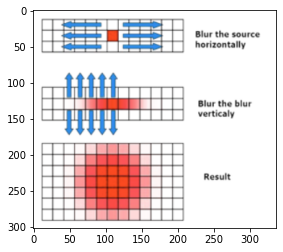

In [3]:
img = cv2.imread('162201.png ') 
plt.imshow(img)

К этому результату можно применить свёртку по вертикали и мы получим такой же результат, как если бы мы применяли двумерную свёртку к нашему пикселю. Если посчитать количество операций при размытии по горизонтали, а затем по вертикали, то **количество операций окажется в разы меньше**.
Такие **фильтры, которые позволяют заменить себя на последовательность 
одномерных, называются сепарабельными**.

Дадим нейросети возможность учить такие фильтры, заменим в нашем 
**inception-блоке** свёртки 3 × 3 на сепарабельные свёртки 1 × 3 и 3 × 1.

Таким образом, мы придумали очень эффективный inception-блок, 
который использует мало параметров и дает лучшее качество, чем набор 
свёрток 3 × 3.

* padding – добавление рамки для скользящего окна 
* stride – сдвиг в рамках скользящего окна
* feature map  – карта фичей
* max pooling – фильтр выбирает максимум из пикселей, покрытых фильтром
* average polling – фильтр выбирает среднее из пикселей, покрытых фильтром
* kernel – ядро свертки
* Сепарабельные фильтры – фильтры одномерной размерности применяемые последовательно по горизонтали и вертикале  

In [1]:
from __future__ import print_function

In [2]:
import argparse # для работы с аргументами командной строки

https://habr.com/ru/company/ruvds/blog/440654/

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

https://habr.com/ru/post/334380/

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Python Imaging Library — библиотека языка Python, предназначенная для работы с растровой графикой.
import PIL

# 1. Данные

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [42]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)

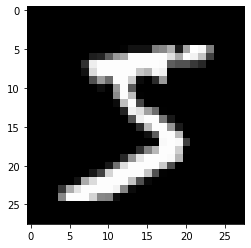

In [45]:
img = dataset1[0][0][0]
plt.imshow(img, cmap="gray")

In [46]:
# Создание именованного кортежа

from collections import namedtuple

Marks = namedtuple('Marks', 'Physics Chemistry Math English')
marks = Marks(90, 85, 95, 100)
print(marks)

Marks(Physics=90, Chemistry=85, Math=95, English=100)


In [105]:
args_namedtuple = namedtuple('args_namedtuple',['batch_size', 'test_batch_size',
                                               'epochs', 'lr', 'gamma','no_cuda',
                                   'dry_run', 'seed', 'log_interval', 'save_model'])

args = args_namedtuple(batch_size = 64, 
                       test_batch_size = 1000, 
                       epochs = 3, # 14, 
                       lr = 1.0,
                       gamma = 0.7,
                       no_cuda = False,
                       dry_run = False,
                       seed = 1,
                       log_interval = 10,
                       save_model = False)
print(args)

# torch.cuda.is_available() - возвращает логическое значение, указывающее, 
# доступна ли в данный момент CUDA

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_cuda

args_namedtuple(batch_size=64, test_batch_size=1000, epochs=3, lr=1.0, gamma=0.7, no_cuda=False, dry_run=False, seed=1, log_interval=10, save_model=False)


False

In [61]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [60]:
import torch
torch.cuda.is_available()

False

In [62]:
# Устанавливает начальное число для генерации случайных чисел. Возвращает объект torch.Generator.
torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

In [66]:
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [67]:
# для параллелизма процесса загрузки данных при поддержке автоматической партии
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs) # произвольное число именованных аргументов
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [68]:
train_loader

In [69]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [72]:
# train_loader.dataset.data

torch.Size([1, 28, 28])


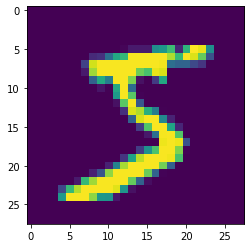

In [76]:
img = np.array(train_loader.dataset.data[0])
print(transform(PIL.Image.fromarray(img)).shape)
plt.imshow(img)

# 2. Модель

class **torch.nn.Module** базовый класс для всех модулей нейронных сетей:
1. nn.Parameter
2. nn.Module
3. nn.functional
4. nn.init

In [83]:
# input and output (N, C, H, W)
# N - batch size
# C - number of channels 
# H, W- height and width of input planes in pixels
m = nn.Conv2d(16, 33, 3, 5)
#               stride=(2, 1), 
#               padding=(4, 2), 
#               dilation=(3, 1))
inp = torch.randn(1, 16, 50, 100)
# inp.shape
out = m(inp)
out.shape

torch.Size([1, 33, 10, 20])

In [81]:
# plt.imshow(inp[0].shape)

In [82]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25) # прореживание 
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # линейное преобразование к входящим данным: y=xA^T+b
        self.fc2 = nn.Linear(128, 10)

#        Класс Net используется для построения модели. 
#        Метод __init__ используется для определения слоев. 
#        После создания определений слоев следующим шагом является определение того, 
#        как данные проходят через эти слои при выполнении прямого прохода по сети:
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # Максимальное 2D-объединение к входному сигналу, состоящему из нескольких входных плоскостей
        x = self.dropout1(x) 
        x = torch.flatten(x, 1) # Выравнивает ввод. Не влияет на размер партии.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) # Применяет softmax, за которым следует логарифм.
        return output
    
#     Первый слой или входной слой модели — conv1, а выходной слой — fc2. 
#     Эта функция определяет, как данные проходят через сеть — данные из входного 
#     слоя conv1 активируются функцией активации ReLU (F.relu()), 
#     затем они передаются на уровень пула, определенный как пул. 
#     Вывод первого уровня сохраняется в переменной x, которая затем
#     отправляется на следующий уровень. 
#     Перед отправкой в классификатор выходные данные последнего свернутого 
#     слоя выравниваются для линейных слоев...
#     ...

https://russianblogs.com/article/738622222/

In [84]:
def train(args, model, device, train_loader, optimizer, epoch):
    # When using PyTorch for training and testing, be sure to specify the train/eval for the instantiated model.
    # При использовании PyTorch для обучения и тестирования обязательно укажите train/eval для созданной модели.
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

In [85]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

**Превращаем ArgumentParser в формат namedtuple для работы не из консоли, а в тетрадке**

Правила:
   batch-size  переходят в batch_size
   default  переходят в значения

<!-- def main():
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args() -->

# 3.Обучение

In [86]:
device

device(type='cpu')

In [87]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

In [88]:
train_loader.dataset[0][1]

5

In [89]:
model = Net().to(device)

In [90]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Перепишем сеть в torch.nn

In [91]:
Net2= nn.Sequential()
Net2.add_module('conv1', nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)))
Net2.add_module('relu1', nn.ReLU())
Net2.add_module('conv2', nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)))
Net2.add_module('relu2', nn.ReLU())
Net2.add_module('Maxpool1', nn.MaxPool2d(2))
Net2.add_module('dropout1', nn.Dropout(p=0.25, inplace=False))
Net2.add_module('flatten', nn.Flatten())
Net2.add_module('relu3', nn.ReLU())
Net2.add_module('fc1', nn.Linear(in_features=9216, out_features=128, bias=True))
Net2.add_module('fc2', nn.Linear(in_features=128, out_features=10, bias=True))

Проверям как работает

In [92]:
for data, target in train_loader:
    data = data.to(device)
    break

In [93]:
data.shape

torch.Size([64, 1, 28, 28])

In [94]:
Net2.to(device).eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu3): ReLU()
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [95]:
Net2(data).shape

torch.Size([64, 10])

In [96]:
Net2(data).shape

torch.Size([64, 10])

In [97]:
model = Net().to(device)

In [98]:
args.lr

1.0

In [99]:
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
# optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [100]:
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

In [106]:
args.epochs

3

In [107]:
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319543
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.352356
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.894894
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.470140
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.565290
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.330813
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.197351
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.358960
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.509870
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.237593
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.263405
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.240222
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.164584
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.230462
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.261193
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.132490
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.260767
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.181649
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.414668
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.141222
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.109540
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.067599
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.141550
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.127350
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.032465
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.056841
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.011820
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.003726
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.005570
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.060104
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.142363
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.031248
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.002501
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.046273
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.094270
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.024492
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.008770
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.026867
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.014689
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.012625


In [108]:
torch.save(model.state_dict(), "mnist_cnn.pt")